In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
from sklearn.preprocessing import   StandardScaler 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier)
from sklearn.model_selection import ( KFold , StratifiedKFold, cross_val_score, GridSearchCV) 
from sklearn.pipeline import Pipeline
from time import time

df = pd.read_csv('resources/glass.csv')
print(df.isnull().any())
print (df.dtypes)
labelDF=df['Type']
df.drop(['Type'], axis = 1, inplace = True)
featuresDF=df
labelDF.value_counts()
featuresDF.describe()


RI      False
Na      False
Mg      False
Al      False
Si      False
K       False
Ca      False
Ba      False
Fe      False
Type    False
dtype: bool
RI      float64
Na      float64
Mg      float64
Al      float64
Si      float64
K       float64
Ca      float64
Ba      float64
Fe      float64
Type      int64
dtype: object


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000


In [2]:
y=labelDF.as_matrix()
X=featuresDF.as_matrix()
columns=featuresDF.columns.values.tolist()
rfClassifier = RandomForestClassifier()
rfClassifier.fit(X, y)
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), rfClassifier.feature_importances_), columns),
             reverse=True))


Features sorted by their score:
[(0.16669999999999999, 'Al'), (0.16289999999999999, 'Mg'), (0.15310000000000001, 'RI'), (0.11840000000000001, 'Ca'), (0.10390000000000001, 'Na'), (0.1003, 'Si'), (0.091800000000000007, 'K'), (0.073300000000000004, 'Ba'), (0.029700000000000001, 'Fe')]


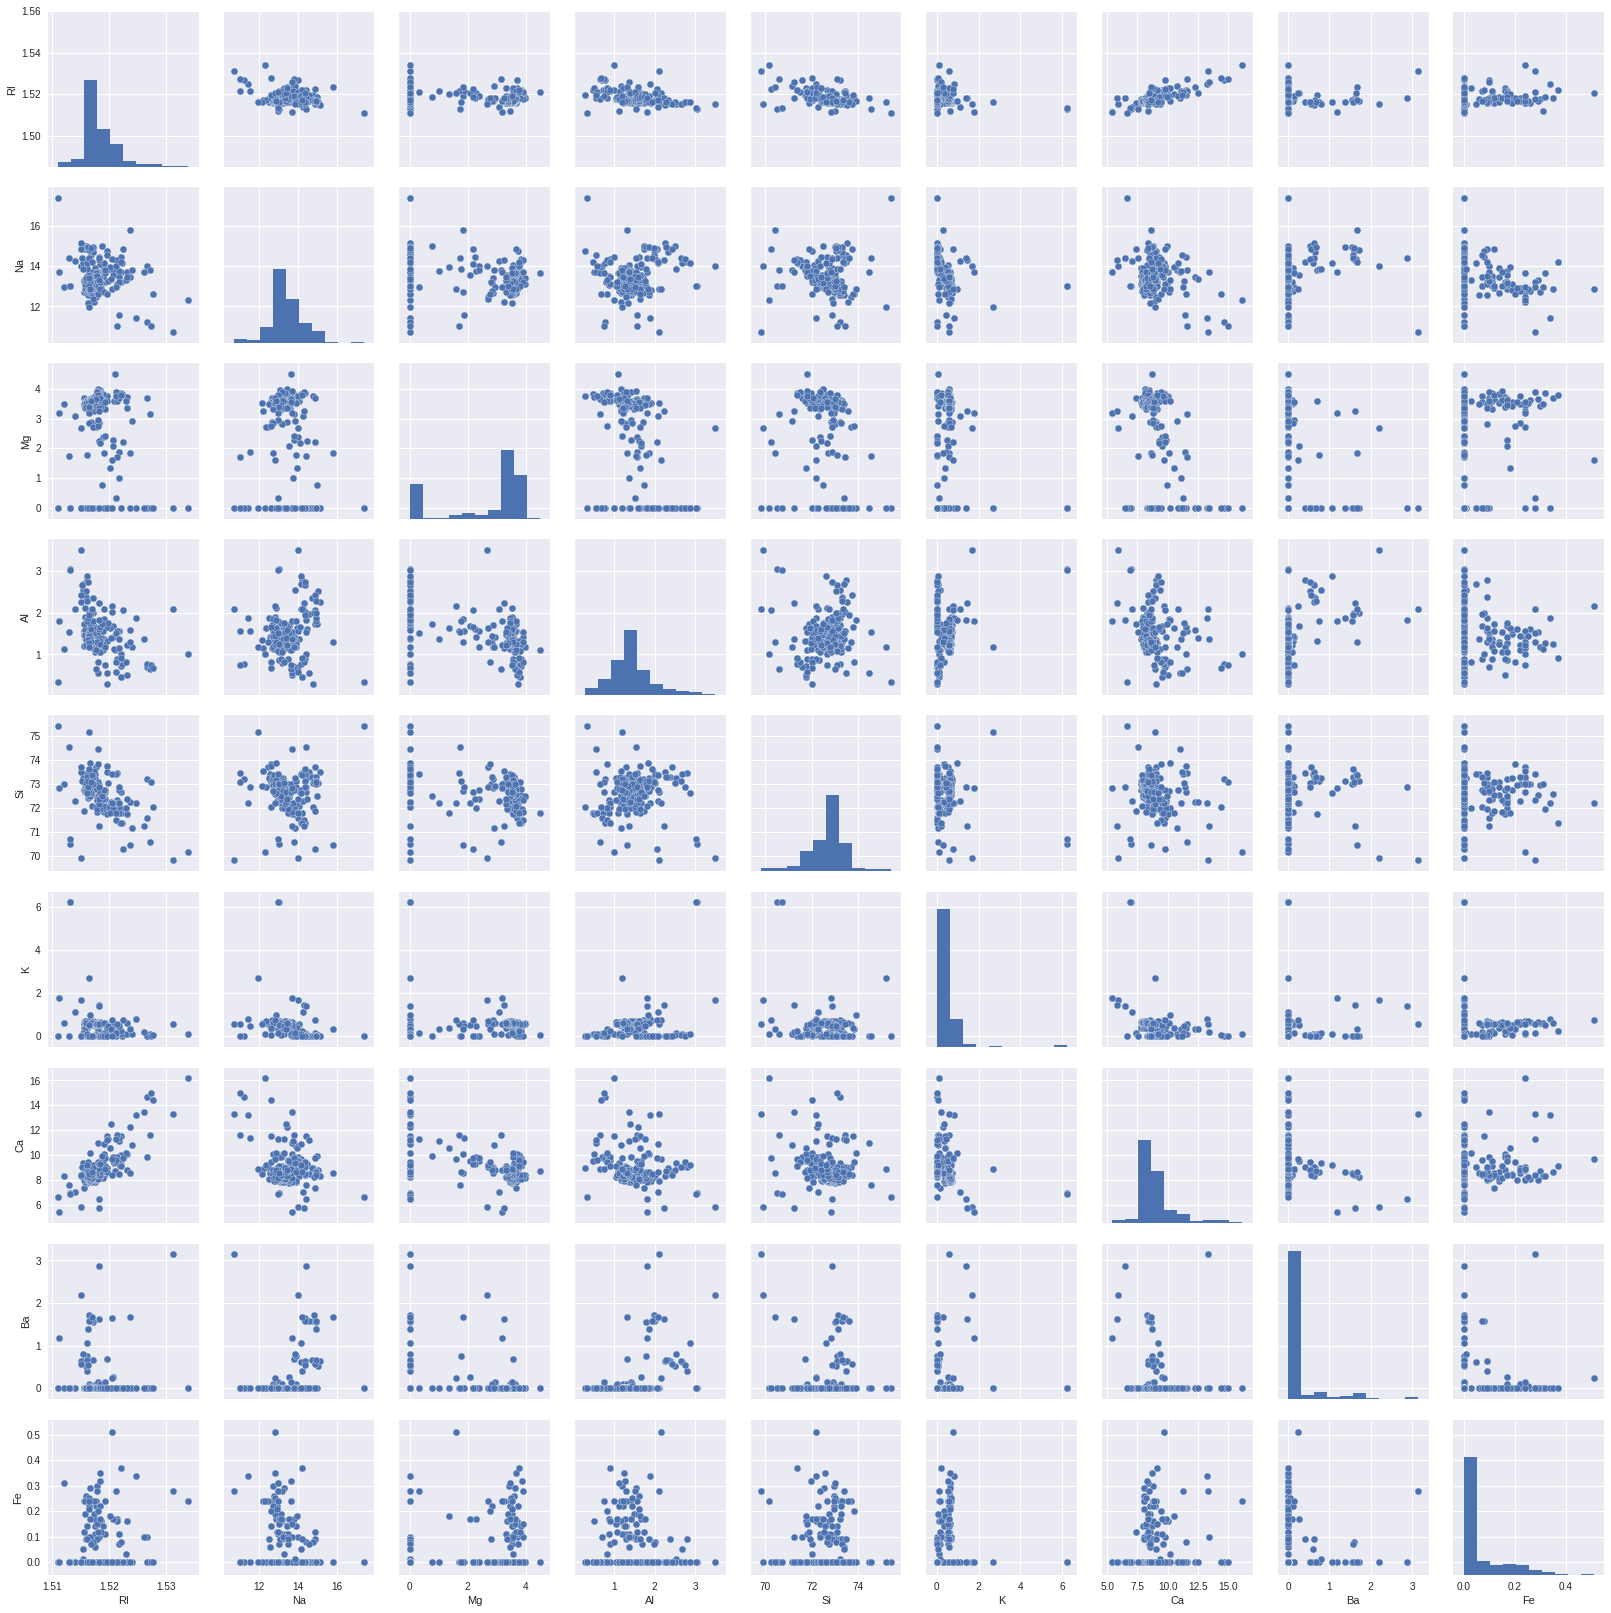

In [3]:
plt.figure(figsize=(8,8))
sns.pairplot(featuresDF,palette='coolwarm')
plt.show()

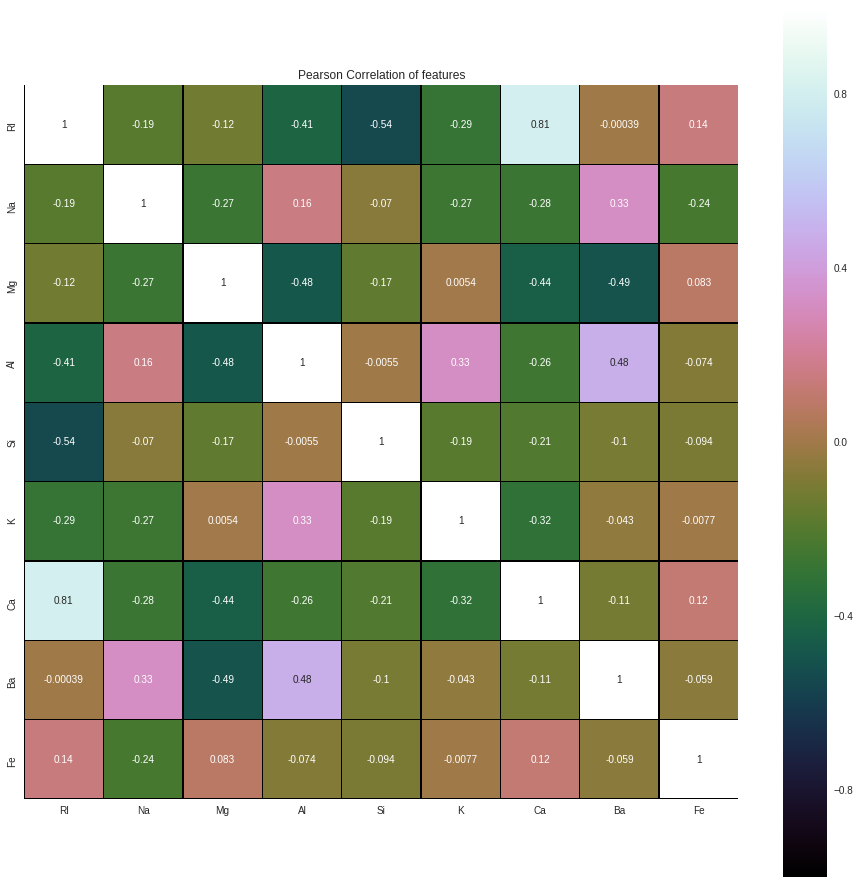

In [5]:
plt.figure(figsize=(16,16))


plt.title('Pearson Correlation of features')

sns.heatmap(featuresDF.astype(float).corr(), linewidths=0.25, vmax=1.0, square=True, cmap="cubehelix", linecolor='k',
            annot=True)

In [6]:



pipelines = []
seed = 7

scoring = 'accuracy'
cv_results, names, times  = [], [] , []
num_folds = 10
n_estimators = 400

pipelines.append( ('GradientBoostingClassifier',
                   Pipeline([ 
                             ('sc', StandardScaler()),
                             ('GradientBoostingClassifier', GradientBoostingClassifier(random_state=seed)) ]) ))
pipelines.append( ('RandomForestClassifier',
                   Pipeline([
                              ('sc', StandardScaler()),
                             ('RandomForestClassifier', RandomForestClassifier(random_state=seed, n_jobs=-1,n_estimators=n_estimators))]) ) )
pipelines.append(('KNeighborsClassifier',
                  Pipeline([ 
                              ('sc', StandardScaler()), ('KNN', KNeighborsClassifier()) ])))                          
pipelines.append( ('ExtraTreesClassifier',
                   Pipeline([
                              ('sc', StandardScaler()),
                          
                             ('ExtraTreesClassifier', ExtraTreesClassifier(random_state=seed, n_estimators=n_estimators)) ]) ))                      


for name, estimator in pipelines:
    start = time()
    kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
    crossValScore = cross_val_score(estimator, X, y, cv=kfold, scoring = scoring,
                                n_jobs=-1) 
    timeSpent = time() - start
    cv_results.append(crossValScore)
    names.append(name)
    times.append(timeSpent)
    msg = "%s: %f (+/- %f) performed in %f seconds" % (name, 100*crossValScore.mean(), 
                                                       100*crossValScore.std(), timeSpent)
    print(msg)



GradientBoostingClassifier: 72.578110 (+/- 11.363932) performed in 1.346559 seconds
RandomForestClassifier: 74.351402 (+/- 12.642138) performed in 1.810834 seconds
KNeighborsClassifier: 66.475751 (+/- 7.208098) performed in 0.199805 seconds
ExtraTreesClassifier: 72.795407 (+/- 12.029410) performed in 1.405668 seconds


In [16]:
pipeline_randomforestclassifier = Pipeline([ 
                      ('scl', StandardScaler()), 
                    ('randomforestclassifier', RandomForestClassifier(random_state=seed, n_jobs=-1) )])


param_grid_randomforestclassifier =  [ {
    'randomforestclassifier__n_estimators': [  600,800,1200], # set of estimators
    }]

kfold = StratifiedKFold(n_splits=num_folds, random_state= seed)
grid_randomforestclassifier = GridSearchCV(pipeline_randomforestclassifier, param_grid= param_grid_randomforestclassifier, cv=kfold, scoring=scoring, verbose= 1, n_jobs=-1)

start = time()
grid_randomforestclassifier = grid_randomforestclassifier.fit(X, y)
end = time()

print("RandomForestClassifier grid search took %.3f seconds" %(end-start))

# Print best tuning parameters
print('Best Accuracy')
print(grid_randomforestclassifier.best_score_ * 100.0)
print('Best tuning parameters')
print(grid_randomforestclassifier.best_params_)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   11.0s finished


RandomForestClassifier grid search took 11.955 seconds
Best Accuracy
75.2336448598
Best tuning parameters
{'randomforestclassifier__n_estimators': 600}
